# **Prototypical Networks for Few-Shot Learning on Omniglot**

*Based on this [colab notebook](https://colab.research.google.com/drive/1TPL2e3v8zcDK00ABqH3R0XXNJtJnLBCd?usp=sharing).*

This notebook offers a demonstration of metric-based Few-Shot Learning (FSL) using **Prototypical Networks** on the **Omniglot** benchmark.

---

## **1. Background**

### **1.1 Few-Shot Learning (FSL)**

In FSL we evaluate and train **episodically**. Each **episode** samples $N$ classes (*N-way*). For each class $K$, we are given a small **support set** $S_k$ of size $K$ (*K-shot*) and a **query set** $Q_k$.  

The learner must classify each query among the $N$ classes using **only** the $N \times K$ labeled supports from that episode.  
Crucially, the classes in an episode are typically **unseen during training**; the model must leverage the supports as a “catalog” describing what each class looks like.

> **Example (3-way 2-shot):** the support contains 2 examples for each of 3 classes. For every query image, the learner must predict its label among those 3 classes.

In practice, many methods are **metric-based**:  
1. use an encoder to project images into a **feature space**,  
2. classify queries by comparing them to the supports in that space.

*(Evaluation tip: report mean accuracy over many episodes, e.g. $T = 10{,}000$, with a 95% confidence interval.)*


![few-shot classification task](https://images.ctfassets.net/be04ylp8y0qc/bZhboqYXfYeW4I88xmMNv/7c5efdc368206feaad045c674b1ced95/1_AteD0yXLkQ1BbjQTB3Ytwg.png?fm=webp)

### **1.2 Prototypical Networks**

Let $ f_\phi(\cdot) $ be an embedding function (a neural encoder).  
For each class $K$ in an episode, we compute the **prototype** as the mean embedding of its supports:

$$
\mathbf{c}_k \;=\; \frac{1}{|S_k|} \sum_{(x,y)\in S_k} f_\phi(x).
$$

Given a query $x$, we score classes via the **negative distance** between its embedding and each prototype:


$$
\text{logit}_k(x) \;=\; -\, d\!\big(f_\phi(x), \mathbf{c}_k\big),
$$

where $ d(\cdot,\cdot) $ is typically the **squared Euclidean** or **(negative) cosine** distance.

The class probabilities are obtained with a softmax:

$$
p_\phi(y = k \mid x) \;=\;
\frac{\exp\!\left(-d(f_\phi(x), \mathbf{c}_k)\right)}
{\sum_{j=1}^{N} \exp\!\left(-d(f_\phi(x), \mathbf{c}_j)\right)}.
$$

The model is trained **episodically** by minimizing the **cross-entropy loss** over the query labels within each episode.


![Prototypical classification](https://images.ctfassets.net/be04ylp8y0qc/45M9UcUp6KnzwDaBHeGZb7/bb2dcda5942ee7320600125ac2310af6/0_M0GSRZri859fGo48.png?fm=webp)


**Notes (implementation):**
- The forward pass usually receives **support images, support labels, and query images**; prototypes are computed on-the-fly.  
- A common backbone is a pretrained CNN (e.g., ResNet-18) with its classifier head removed.  
- When using cosine distance, embeddings are often **$\ell_2$-normalized**:  
  $ f_\phi(x) \leftarrow f_\phi(x) / \| f_\phi(x) \| $.


### **1.3 Omniglot dataset**
We'll use [Omniglot](https://github.com/brendenlake/omniglot), a popular MNIST-like benchmark
for few-shot classification. It contains 1623 characters from 50 different alphabets. Each character has been written by
20 different people.

It's part of the `torchivision` package, so it's easy to download
and work with.

---

## **2. Practice**

In [1]:
import numpy as np
import pandas as pd
import torch
import math
import torch.nn.functional as F
import torch.optim as optim

from torch import Tensor, nn, optim
from torch.utils.data import DataLoader, Subset
from torchvision import transforms, utils
from torchvision.datasets import Omniglot
from torchvision.models import resnet18
from tqdm import tqdm
from functools import partial
from matplotlib import pyplot as plt
from copy import deepcopy

Seed:

In [2]:
# Reproducibility
SEED = 42
torch.manual_seed(SEED)
rng_global = np.random.default_rng(SEED)
rng_train = np.random.default_rng(SEED + 1)
rng_val   = np.random.default_rng(SEED + 2)
rng_test  = np.random.default_rng(SEED + 3)

Settings:

In [3]:
# Few-shot episode configuration
N_WAY = 5        # Number of classes per task
K_SHOT = 5       # Support examples per class
Q_QUERY = 10     # Query examples per class

# Training configuration
FREEZE_BACKBONE = True  # If only last backbone block is trained
N_TRAINING_TASKS = 20_000   # Number of training episodes
N_VAL_TASKS = 1_000         # Number of validation episodes
N_TEST_TASKS = 1_000        # Number of test episodes

# Validation setting
LOG_EVERY = 20
VAL_EVERY = 500            # validate every VAL_EVERY episodes
PATIENCE  = 5              # early stopping after PATIENCE consecutive downgrades

Utility functions:

In [4]:
def plot_images(images: torch.Tensor, title: str, images_per_row: int):
    """
    images: (B, C, H, W)
    """
    grid = utils.make_grid(images, nrow=images_per_row, padding=1)
    plt.figure()
    plt.title(title)
    plt.imshow(grid.permute(1, 2, 0).cpu())
    plt.axis('off')
    plt.tight_layout()
    plt.show()

In [5]:
def get_dataset_labels(ds):
    """
    Return a 1D numpy array of dataset labels for common torchvision datasets.
    Tries several known attributes, then falls back to a light scan.
    """
    # 1) Standard torchvision datasets (e.g., CIFAR, MNIST)
    if hasattr(ds, "targets") and len(ds.targets) > 0:
        return np.array(ds.targets)

    # 2) Some datasets use .labels
    if hasattr(ds, "labels") and len(ds.labels) > 0:
        return np.array(ds.labels)

    # 3) Omniglot (torchvision) keeps a flat list of (path, class_idx)
    if hasattr(ds, "_flat_character_images") and len(ds._flat_character_images) > 0:
        return np.array([lbl for _, lbl in ds._flat_character_images])

    # 4) Fallback: iterate WITHOUT forcing heavy transforms if possible.
    labels = []
    for i in range(len(ds)):
        _, y = ds[i]
        labels.append(int(y))
    return np.array(labels)

In [6]:
def sliding_average(xs, k=10):
    if len(xs) == 0:
        return 0.0
    if len(xs) < k:
        return float(sum(xs) / len(xs))
    return float(sum(xs[-k:]) / k)

### **2.1 Environment**

#### **2.1.1 Omniglot dataset**

We begin by defining the transformations applied to the training and test sets. These differ because random transformations can be applied to the training samples, while the test set must remain consistent for evaluation.

In [7]:
image_size = 28

train_tf = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.RandomResizedCrop(image_size),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
])

eval_tf = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize([int(image_size * 1.15), int(image_size * 1.15)]),
    transforms.CenterCrop(image_size),
    transforms.ToTensor(),
])

We now instantiate the Omniglot splits used throughout our experiments:
- `train_full` and `val_full` are drawn from the **background** alphabets (meta-train pool), with training samples receiving `train_tf` (randomized) and validation samples `eval_tf` (deterministic).
- `test_set` uses the **evaluation** alphabets (`background=False`), kept disjoint from training to prevent leakage.

All splits are stored under `./data` and fetched on demand via `download=True`.

> *Note.* Since `train_full` and `val_full` originate from the same background pool, they must be separated explicitly (e.g., by characters rather than images) before episodic sampling.


In [8]:
train_full = Omniglot(root="./data", background=True, transform=train_tf, download=True)
val_full   = Omniglot(root="./data", background=True, transform=eval_tf,  download=True)
test_set   = Omniglot(root="./data", background=False, transform=eval_tf, download=True)

We now **disjoin** the validation set from the training one:

In [9]:
# Class albels on training/validaton dataset
labels_train_val = get_dataset_labels(train_full)  # shape (N,)
classes_train_val = np.unique(labels_train_val)

# Extract validation set labels
val_ratio = 0.2
n_val = max(1, int(len(classes_train_val) * val_ratio))
val_classes = set(rng_global.choice(classes_train_val, size=n_val, replace=False))

# Sample indexes for train and validation sets
train_idx = [i for i, y in enumerate(labels_train_val) if y not in val_classes]
val_idx   = [i for i, y in enumerate(labels_train_val) if y in  val_classes]

# Train and validation sets
train_set = Subset(train_full, train_idx)
val_set   = Subset(val_full,   val_idx)

Then we create the **labels** for the splits:

In [10]:
# Train / Validation
train_labels = labels_train_val[train_idx]
val_labels   = labels_train_val[val_idx]

train_class_indices = {c: np.where(train_labels == c)[0] for c in np.unique(train_labels)}
val_class_indices   = {c: np.where(val_labels   == c)[0] for c in np.unique(val_labels)}

# Test
test_labels = get_dataset_labels(test_set)
test_class_indices = {c: np.where(test_labels == c)[0] for c in np.unique(test_labels)}

#### **2.1.2 Episodic DataLoader**

Now that we have a model, we need to evaluate it on **few-shot tasks**.
A standard PyTorch `DataLoader` builds mini-batches of images without
considering whether they belong to a support or query set.
For few-shot learning, we need something more specific:

1. **Balanced classes**: each batch must contain examples from exactly `n_way` classes.
2. **Support / query split**: for each class, we need `k_shot` images in the support set
   and `q_query` images in the query set.

To achieve this, we use a custom **task sampler** and a custom **collate function**:

- The sampler samples `n_way` classes and then `k_shot + q_query` images from each class.
- The collate function splits the sampled images into 5 items:
  1. support images
  2. support labels (in range `[0, n_way)`)
  3. query images
  4. query labels (in range `[0, n_way)`)
  5. a mapping from episodic labels `[0, n_way)` to their original dataset labels

This way, each batch is a complete *episode* for few-shot training or evaluation.


In [11]:
def episodic_collate_fn(
    batch,
    n_way: int,
    k_shot: int,
    q_query: int,
):
    """
    Args:
        batch: list of (image, label) pairs sampled episodically, grouped by class.
    Returns:
        support_images: (n_way * k_shot, C, H, W)
        support_labels: (n_way * k_shot,)   values in [0, n_way)
        query_images:   (n_way * q_query, C, H, W)
        query_labels:   (n_way * q_query,)  values in [0, n_way)
        true_class_ids: list[int] of original dataset class ids (len = n_way)
    """
    # Unzip images and labels
    imgs, labs = zip(*batch)

    # Ensure tensors (most torchvision datasets already return tensors)
    if not torch.is_tensor(imgs[0]):
        # If your dataset returns PIL images, convert to tensor here or in the dataset __getitem__
        imgs = [torch.as_tensor(np.array(im)).permute(2, 0, 1) for im in imgs]

    images = torch.stack(imgs)              # (n_way*(k_shot+q_query), C, H, W)
    labels = torch.tensor([int(l) for l in labs])  # original dataset labels

    n_per = k_shot + q_query
    assert images.size(0) == n_way * n_per, "Batch size doesn't match n_way*(k_shot+q_query)"

    # Reshape by class assuming sampler concatenated per-class blocks in order
    images = images.view(n_way, n_per, *images.shape[1:])  # (N, S+Q, C, H, W)
    labels = labels.view(n_way, n_per)                     # (N, S+Q)

    # True class ids = first label of each class block (original dataset ids)
    true_class_ids = [int(labels[i, 0].item()) for i in range(n_way)]

    # Map dataset labels -> episodic labels [0..n_way)
    label_map = {cid: i for i, cid in enumerate(true_class_ids)}
    episodic_labels = labels.clone()
    for i, cid in enumerate(true_class_ids):
        episodic_labels[i] = label_map[cid]

    # Split support / query
    support_images = images[:, :k_shot].reshape(-1, *images.shape[2:])
    query_images   = images[:, k_shot:].reshape(-1, *images.shape[2:])
    support_labels = episodic_labels[:, :k_shot].reshape(-1)
    query_labels   = episodic_labels[:, k_shot:].reshape(-1)

    return support_images, support_labels, query_images, query_labels, true_class_ids

We now need to define the **collate function**. In fact, the **DataLoader** calls the collate with only a batch, while our `episodic_collate_fn` also needs `n_way`, `k_shot`, and `q_query`.

Using `partial()` pre-fills those arguments so you get a function with exactly the signature the **DataLoader** expects.

In [12]:
collate_fn = partial(episodic_collate_fn, n_way=N_WAY, k_shot=K_SHOT, q_query=Q_QUERY)

For the batch sampler, we use a custom `EpisodicBatchSampler` so that each batch is already a full N-way K-shot episode. It yields index arrays arranged as per-class blocks of `k_shot + q_query`, which the collate then splits into support and query.

In [13]:
class EpisodicBatchSampler:
    """
    Yields index arrays for N-way K-shot episodes with per-class blocks.
    Keeps memory low and guarantees reproducibility via an injected RNG.
    """
    def __init__(self, class_indices, n_way, k_shot, q_query, n_tasks, rng):
        self.class_indices = class_indices
        self.n_way = n_way
        self.k_shot = k_shot
        self.q_query = q_query
        self.n_tasks = n_tasks
        self.rng = rng
        self.n_per_class = k_shot + q_query
        self.all_classes = list(class_indices.keys())

    def __len__(self):
        return self.n_tasks

    def __iter__(self):
        for _ in range(self.n_tasks):
            chosen = self.rng.choice(self.all_classes, size=self.n_way, replace=False)
            batch = []
            for c in chosen:
                pool = self.class_indices[c]
                if len(pool) < self.n_per_class:
                    raise ValueError(
                        f"Class {c} has {len(pool)} samples; need {self.n_per_class}."
                    )
                idx = self.rng.choice(pool, size=self.n_per_class, replace=False)
                batch.append(idx)
            yield np.concatenate(batch)

We can now build our **DataLoaders**:



In [14]:
# Train DataLoader
train_loader = DataLoader(
    train_set,
    batch_sampler=EpisodicBatchSampler(train_class_indices, N_WAY, K_SHOT, Q_QUERY, N_TRAINING_TASKS, rng_train),
    collate_fn=collate_fn,
    num_workers=2,
    pin_memory=True,
)

# Validation DataLoader
val_loader = DataLoader(
    val_set,
    batch_sampler=EpisodicBatchSampler(val_class_indices, N_WAY, K_SHOT, Q_QUERY, N_VAL_TASKS, rng_val),
    collate_fn=collate_fn,
    num_workers=2,
    pin_memory=True,
)

# Test DataLoader
test_loader = DataLoader(
    test_set,
    batch_sampler=EpisodicBatchSampler(test_class_indices, N_WAY, K_SHOT, Q_QUERY, N_TEST_TASKS, rng_test),
    collate_fn=collate_fn,
    num_workers=2,
    pin_memory=True,
)

Let's see an apisode from our test dataset:

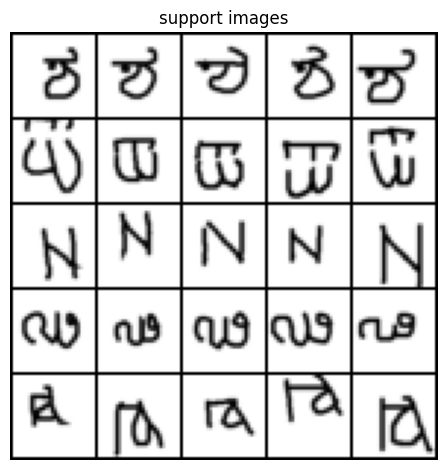

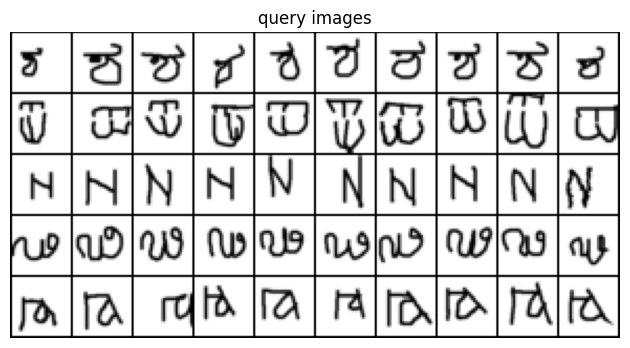

In [15]:
(
    example_support_images,
    example_support_labels,
    example_query_images,
    example_query_labels,
    example_class_ids,
) = next(iter(test_loader))

plot_images(example_support_images, "support images", images_per_row=K_SHOT)
plot_images(example_query_images, "query images", images_per_row=Q_QUERY)

#### **2.1.3 Prototypical Network module**

Now, we define Prototypical Networks as a torch module:

1. We initiate `PrototypicalNetworks` with a *backbone*. This is the feature extractor we were talking about.
Here, we use as backbone a ResNet18 pretrained on ImageNet, with its head chopped off and replaced by an `Identity`
layer. The output of the backbone, for an input image, will be a 512-dimensional feature vector.
2. The forward method doesn't only take one input tensor: in order to predict the labels of query images,
we also need support images and labels as inputs of the model.

In [16]:
class PrototypicalNetworks(nn.Module):
    def __init__(self, backbone: nn.Module, metric: str = "sqeuclidean"):
        """
        Prototypical Networks module.

        Args:
            backbone: feature extractor (e.g. ResNet18 without final FC).
            metric: distance metric ("sqeuclidean", "euclidean", "cosine").
        """
        super().__init__()
        self.backbone = backbone
        self.metric = metric

    def _compute_prototypes(self, z_support: torch.Tensor, support_labels: torch.Tensor):
        """
        Compute class prototypes as the mean of support embeddings.

        Args:
            z_support: support embeddings, shape (Ns, D)
            support_labels: support labels, shape (Ns,)

        Returns:
            prototypes: (N, D)
            classes: (N,) tensor with the class ids (order matches prototypes)
        """
        classes = torch.unique(support_labels)
        protos = []
        for c in classes:
            mask = (support_labels == c)
            proto = z_support[mask].mean(dim=0)
            protos.append(proto)
        prototypes = torch.stack(protos, dim=0)
        return prototypes, classes

    def _pairwise_distance(self, z_query: torch.Tensor, prototypes: torch.Tensor) -> torch.Tensor:
        """
        Compute distances between query embeddings and prototypes.

        Args:
            z_query: (Nq, D)
            prototypes: (N, D)

        Returns:
            distances: (Nq, N)
        """
        if self.metric == "sqeuclidean":
            q2 = (z_query ** 2).sum(dim=1, keepdim=True)      # (Nq, 1)
            p2 = (prototypes ** 2).sum(dim=1, keepdim=True).T # (1, N)
            cross = z_query @ prototypes.T                    # (Nq, N)
            d2 = q2 + p2 - 2 * cross
            return d2.clamp_min(0.0)
        elif self.metric == "euclidean":
            return torch.cdist(z_query, prototypes, p=2)
        elif self.metric == "cosine":
            zq = F.normalize(z_query, dim=1)
            pr = F.normalize(prototypes, dim=1)
            return 1.0 - (zq @ pr.T)
        else:
            raise ValueError(f"Unknown metric: {self.metric}")

    def forward(
        self,
        support_images: torch.Tensor,   # (Ns, C, H, W)
        support_labels: torch.Tensor,   # (Ns,) episodic labels [0..N-1]
        query_images: torch.Tensor,     # (Nq, C, H, W)
    ):
        z_support = self.backbone(support_images)
        z_query   = self.backbone(query_images)

        prototypes, classes = self._compute_prototypes(z_support, support_labels)

        dists = self._pairwise_distance(z_query, prototypes)
        scores = -dists
        return scores, classes


# Build backbone (ResNet18 pre-trained on ImageNet, output = 512-D features)
backbone = resnet18(weights="IMAGENET1K_V1")
backbone.fc = nn.Identity()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = PrototypicalNetworks(backbone, metric="euclidean").to(device)


### **2.2 Baseline evaluation**
We now evaluate our baseline model before fine-tuning it, to understand our starting point. As we already said, we want to report the **mean accuracy with 95% CI** over `N_TEST_TASKS` episodes.

We use an evaluation function we'll reuse later for evaluating our final model:

In [17]:
@torch.no_grad()
def evaluate(data_loader: DataLoader):
    per_episode_acc = []
    for (
        support_images,
        support_labels,
        query_images,
        query_labels,
        _true_class_ids,
    ) in data_loader:
        model.eval()
        scores, _ = model(
            support_images.to(device),
            support_labels.to(device),
            query_images.to(device),
        )
        preds = scores.argmax(dim=1).cpu()
        correct = (preds == query_labels).sum().item()
        total = query_labels.numel()
        per_episode_acc.append(correct / total)

    T = len(per_episode_acc)
    mean_acc = sum(per_episode_acc) / T
    var = sum((a - mean_acc) ** 2 for a in per_episode_acc) / (T - 1) if T > 1 else 0.0
    std = math.sqrt(var)
    ci95 = 1.96 * (std / math.sqrt(T)) if T > 0 else 0.0
    return T, float(mean_acc), float(ci95)

We can now measure the **accuracy** of our baseline model:

In [18]:
model.eval()
T, test_acc, test_ci = evaluate(test_loader)
print(f"[test] acc={100*test_acc:.2f}% ± {100*test_ci:.2f}% (95% CI on {T} tasks)")

[test] acc=86.35% ± 0.45% (95% CI on 1000 tasks)


### **2.3 Episodic fine-tuning**

We fine-tune the encoder **episode by episode**. Each training step:

1. samples an N-way K-shot task,
2. builds class prototypes from the support set,
3. predicts query labels,
4. updates the encoder via cross-entropy.

Every `VAL_EVERY` steps we **pause training** to run a **validation block** on disjoint episodic tasks, reporting mean accuracy and a 95% CI. We keep the **best checkpoint** (highest validation accuracy) and apply **early stopping** if validation does not improve for `PATIENCE` validation rounds. At the end, we **restore** the best model before testing.

We optimize **cross-entropy** on query predictions using **Adam**. You may:
- fine-tune the whole encoder, or
- partially unfreeze (e.g., last residual block) it.

To reduce overfitting and keep BN stable under small episodic batches, we also force all BatchNorm layers to `eval()` avoiding updates.

In [19]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=0.0)

# Freeze all but the last block
if FREEZE_BACKBONE:
  for name, p in model.backbone.named_parameters():
      p.requires_grad = ("layer4" in name)  # only train last block

def set_bn_eval(m):
    if isinstance(m, nn.BatchNorm2d):
        m.eval()
        for p in m.parameters():
            p.requires_grad = False
model.backbone.apply(set_bn_eval)

trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Trainable parameters: {(trainable/(10**6)):.2f}M (on {sum(p.numel() for p in model.parameters())/(10**6):.2f}M)")

Trainable parameters: 8.39M (on 11.18M)


#### **2.3.2 Episodic training loop**

We need to iterate over episodic batches, logging a smoothed loss:
- Every `VAL_EVERY` steps it switches to eval, runs the **validation episodes** (reporting mean accuracy with a 95% CI), and **checkpoints** the best model.
- If validation does not improve for `PATIENCE` validations, we trigger **early stopping**.
- At the end, we **restore the best weights** before testing.



To do this, we exploit `fit_one_episode`, which runs **one few-shot episode** with gradients enabled: the model consumes support (images + labels), builds class prototypes internally, scores the query set, computes **cross-entropy** on query labels, backpropagates, and performs an **optimizer step**. Returns the scalar loss for logging.

In [20]:
@torch.enable_grad()
def fit_one_episode(
    support_images: torch.Tensor,
    support_labels: torch.Tensor,
    query_images: torch.Tensor,
    query_labels: torch.Tensor,
) -> float:
    """
    Single episodic training step: build prototypes on support, predict queries, optimize CE on query labels.
    """
    model.train()
    optimizer.zero_grad()

    scores, _ = model(
        support_images.to(device),
        support_labels.to(device),
        query_images.to(device),
    )
    loss = criterion(scores, query_labels.to(device))
    loss.backward()

    optimizer.step()
    return float(loss.item())

In [21]:
all_loss  = []
best_val_acc = -1.0
patience_ctr = 0
best_state   = None

model.train()
with tqdm(enumerate(train_loader), total=len(train_loader), desc="Episodic training") as tq:
    for step, (
        support_images,
        support_labels,
        query_images,
        query_labels,
        _true_class_ids,
    ) in tq:
        # ---- TRAIN ----
        loss_val = fit_one_episode(support_images, support_labels, query_images, query_labels)
        all_loss.append(loss_val)

        if step % LOG_EVERY == 0:
            tq.set_postfix(loss=sliding_average(all_loss, LOG_EVERY))

        # ---- PERIODIC VALIDATION ----
        if (step + 1) % VAL_EVERY == 0:
            model.eval()
            T, val_acc, val_ci = evaluate(val_loader)   # evaluation
            tq.write(f"\t[val] step {step+1:05d}: acc={100*val_acc:.2f}% ± {100*val_ci:.2f}% (CI 95% on {T} tasks)")

            # best model checkpoint
            if val_acc > best_val_acc + 1e-6:
                best_val_acc = val_acc
                patience_ctr = 0
                best_state = {
                    "model": deepcopy(model.state_dict()),
                    "optimizer": deepcopy(optimizer.state_dict()),
                    "step": step + 1,
                    "val_acc": best_val_acc,
                }
            else:
                patience_ctr += 1
                if patience_ctr >= PATIENCE:
                    tq.write(f"Early stopping (no improvement for {PATIENCE} validations).")
                    break

            model.train()

# Restore the best model
if best_state is not None:
    model.load_state_dict(best_state["model"])
    optimizer.load_state_dict(best_state["optimizer"])


Episodic training:   3%|▎         | 502/20000 [01:16<20:15:46,  3.74s/it, loss=0.782]

	[val] step 00500: acc=89.53% ± 0.42% (CI 95% on 1000 tasks)


Episodic training:   5%|▌         | 1002/20000 [02:31<24:43:43,  4.69s/it, loss=0.794]

	[val] step 01000: acc=92.25% ± 0.38% (CI 95% on 1000 tasks)


Episodic training:   8%|▊         | 1503/20000 [03:46<23:14:57,  4.52s/it, loss=0.705]

	[val] step 01500: acc=92.23% ± 0.38% (CI 95% on 1000 tasks)


Episodic training:  10%|█         | 2002/20000 [05:01<25:31:43,  5.11s/it, loss=0.631]

	[val] step 02000: acc=93.48% ± 0.34% (CI 95% on 1000 tasks)


Episodic training:  13%|█▎        | 2502/20000 [06:16<22:33:47,  4.64s/it, loss=0.641]

	[val] step 02500: acc=92.27% ± 0.38% (CI 95% on 1000 tasks)


Episodic training:  15%|█▌        | 3002/20000 [07:30<20:32:37,  4.35s/it, loss=0.596]

	[val] step 03000: acc=94.29% ± 0.31% (CI 95% on 1000 tasks)


Episodic training:  18%|█▊        | 3502/20000 [08:45<21:20:52,  4.66s/it, loss=0.559]

	[val] step 03500: acc=94.18% ± 0.30% (CI 95% on 1000 tasks)


Episodic training:  20%|██        | 4002/20000 [10:02<21:34:05,  4.85s/it, loss=0.666]

	[val] step 04000: acc=94.61% ± 0.30% (CI 95% on 1000 tasks)


Episodic training:  23%|██▎       | 4502/20000 [11:17<23:00:50,  5.35s/it, loss=0.623]

	[val] step 04500: acc=94.61% ± 0.31% (CI 95% on 1000 tasks)


Episodic training:  25%|██▌       | 5002/20000 [12:33<20:11:24,  4.85s/it, loss=0.645]

	[val] step 05000: acc=94.36% ± 0.31% (CI 95% on 1000 tasks)


Episodic training:  28%|██▊       | 5502/20000 [13:48<18:20:34,  4.55s/it, loss=0.567]

	[val] step 05500: acc=94.86% ± 0.30% (CI 95% on 1000 tasks)


Episodic training:  30%|███       | 6002/20000 [15:03<15:45:43,  4.05s/it, loss=0.576]

	[val] step 06000: acc=95.61% ± 0.26% (CI 95% on 1000 tasks)


Episodic training:  33%|███▎      | 6502/20000 [16:17<15:46:29,  4.21s/it, loss=0.629]

	[val] step 06500: acc=95.32% ± 0.27% (CI 95% on 1000 tasks)


Episodic training:  35%|███▌      | 7002/20000 [17:33<18:09:35,  5.03s/it, loss=0.606]

	[val] step 07000: acc=94.78% ± 0.31% (CI 95% on 1000 tasks)


Episodic training:  38%|███▊      | 7502/20000 [18:50<16:56:28,  4.88s/it, loss=0.552]

	[val] step 07500: acc=94.60% ± 0.32% (CI 95% on 1000 tasks)


Episodic training:  40%|████      | 8002/20000 [20:11<15:22:43,  4.61s/it, loss=0.528]

	[val] step 08000: acc=95.49% ± 0.28% (CI 95% on 1000 tasks)


Episodic training:  42%|████▏     | 8499/20000 [21:28<29:03,  6.60it/s, loss=0.518]

	[val] step 08500: acc=95.10% ± 0.30% (CI 95% on 1000 tasks)
Early stopping (no improvement for 5 validations).


#### Final evaluation

After the episodic fine-tuning, we evaluate again on the **test split** with episodic testing (same as before), reporting **mean accuracy ± 95% CI** over `N_TEST_TASKS` episodes.


In [22]:
model.eval()
T, test_acc, test_ci = evaluate(test_loader)
print(f"[test] acc={100*test_acc:.2f}% ± {100*test_ci:.2f}% (95% CI on {T} tasks)")

[test] acc=93.38% ± 0.32% (95% CI on 1000 tasks)
